In [2]:
import display
from potential_initialization import *

In [103]:
import ndsplines
%load_ext autoreload
%autoreload 2
def derivatives_of_grid(grid, potiential_grid):
    ndsplines.make_interp_spline()
    potiential_grid

pb, pp = get_potential_basis("junction")
# pp = pp.astype(np.float128)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
def init_analytic_properties(interp):
    jac = [interp.derivative(i) for i in range(3)]
    hess = [[interp.derivative(i).derivative(j) for i in range(3)] for j in range(3)]
    return lambda x: np.array([func(x) for func in jac]).reshape(3),\
          lambda x: np.array([[func(x) for func in col] for col in hess]).reshape((3, 3))

def get_pseudo_potential_interpolation(model, srange=[[-1, 1], [-0.1, 0.1], [0.05, 0.1]], stepsize=0.005):
    
    pb, pp = get_potential_basis(model)
    field_points = get_field_points(srange, stepsize)
    interp = ndsplines.make_interp_spline(field_points, pp)
    return interp, *init_analytic_properties(interp)
# field_points.shape, pp.shape

def get_potential_basis_interpolation(model, srange=[[-1, 1], [-0.1, 0.1], [0.05, 0.1]], stepsize=0.005):
    
    pb, pp = get_potential_basis(model)

    field_points = get_field_points(srange, stepsize)
    interp, jac, hess = [], [], []
    for i in tqdm(range(pb.shape[-1])):
        itp = ndsplines.make_interp_spline(field_points, pb[...,i])
        interp.append(itp)
        j, h = init_analytic_properties(itp)
        jac.append(j)
        hess.append(h)
    return interp, jac, hess

pseudo_interp, pseudo_jac, pseudo_hess  = get_pseudo_potential_interpolation("junction")
interp, jac, hess = get_potential_basis_interpolation("junction")

100%|██████████| 94/94 [01:03<00:00,  1.49it/s]


In [97]:
from scipy.optimize import minimize

%matplotlib qt 


def find_radial_minimum(interp, grad=None, hessian=None, srange=[[-1, 1], [-0.1, 0.1], [0.05, 0.1]], stepsize=0.005, plot=False):
    xtick, ytick, ztick = get_field_point_ticks(srange, stepsize=stepsize)
    locations = []
    for x in tqdm(xtick):
        func = lambda y: interp([x, y[0], y[1]])
        jac = lambda y: grad([x, y[0], y[1]])[1:]
        # hess = lambda y: hessian([x, y[0], y[1]])[1:, 1:] 
        res = minimize(func, x0=[0, 0.07], jac=jac, tol=1e-15)
        locations.append(res.x)
    locations = np.array(locations)
    if plot:
        figure = plt.figure()
        axes = figure.add_subplot(projection='3d')
        axes.scatter(xtick, locations[:, 0], locations[:, 1])
        plt.show()
    return locations


locations = find_radial_minimum(pseudo_interp, grad=pseudo_jac, plot=True)


100%|██████████| 400/400 [00:04<00:00, 82.70it/s]


In [98]:
xtick, ytick, ztick = get_field_point_ticks([[-1, 1], [-0.1, 0.1], [0.05, 0.1]], stepsize=0.005)
figure = plt.figure()
axes = figure.add_subplot(projection='3d')
axes.scatter(xtick, locations[:, 0], locations[:, 1])
plt.show()

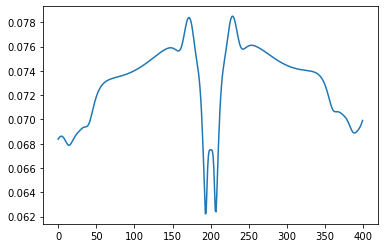

In [99]:
%matplotlib inline
plt.plot(locations[:, 1])

In [82]:
from scipy.optimize import minimize
def trap_frequency(location, hess):
    q = 1.6e-19
    m = 0.171/6.02e23
    hessian = np.array(hess(location))
    eig, eigv = np.linalg.eig(hessian)
    return (q * eig / m) ** 0.5 / (2 * np.pi / 1e6)  , eigv

ion_location = minimize(pseudo_interp, [0.6, 0, 0.07], jac=pseudo_jac, tol=1e-15).x
ion_location = np.array([0.6, 0, 0.074])
freq, direction = trap_frequency(ion_location, pseudo_hess)

In [102]:
q = 1.6e-19
m = 0.171/6.02e23
hessian = np.array(pseudo_hess((ion_location)))
eig = np.array([hessian[0, 0], hessian[1, 1], hessian[2, 2]])
freq = (q * eig / m) ** 0.5 / (2 * np.pi )
(freq / np.array([0.0110397, 3.06111, 3.15968]) ) 

array([0.99877762, 1.00256523, 0.97643917])

In [84]:
pseudo_interp([0.6, 0, 0.074]) * 1e6

array([-0.24923488])

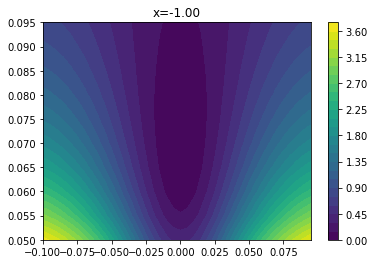

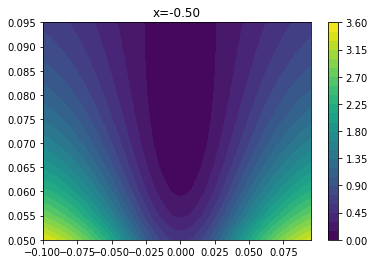

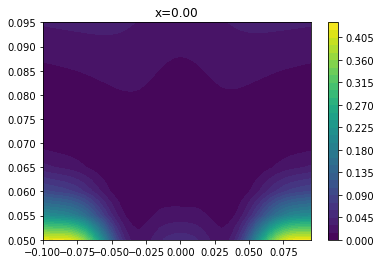

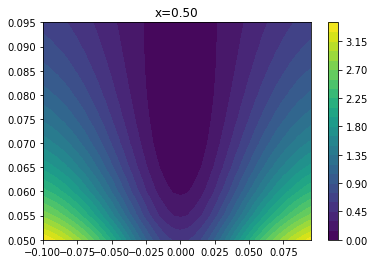

In [105]:
shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.1]]

for i in np.linspace(-1, 0.5, 4):
    display.potential_slicex(pp * 1e6, shuttle_range, i)

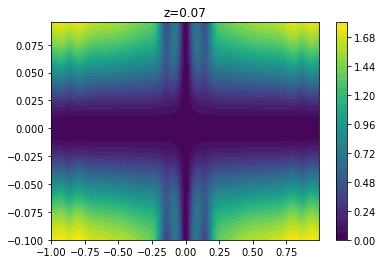

In [106]:
%matplotlib inline 
voltage = np.random.uniform(-10, 10, size=94)
voltage = np.zeros(94)
slice = display.total_potential_slice(voltage, pb, pp * 1e6, shuttle_range, 0.07)